# Importazione librerie

Importiamo tutte le librerie necessarie per il Notebook:

In [1]:
import base64  # fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
import datetime  # fornisce funzioni e classi per lavorare con date e tempi
import lime # fornisce metodi di spiegabilità algoritmic
import lime.lime_tabular 
import matplotlib.pyplot as plt # fornisce funzioni per generare grafici
import networkx as nx # fornisce funzioni per la creazione di grafi
import numpy as np # fornisce vaarie utilities per lavorare con array
import os 
import pandas as pd # fornisce vaarie utilities per lavorare con array
import preprocess_dataset as ut
import random 
import seaborn as sns
import tensorflow as tf 

from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
from keras_tuner import HyperModel, GridSearch, RandomSearch
from keras_tuner.tuners import BayesianOptimization
from lime import lime_tabular
from math import sqrt
from scipy.interpolate import BSpline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import check_random_state
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tfkan import DenseKAN

Impostiamo in seme casuale a 0 per poter rendere l'esperimento ripetibile:

In [2]:
#impostazione del valore del seme causale
seed_value = 0

#impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#controllo che il seme sia stato correttamente impostato
check_random_state(seed_value)

RandomState(MT19937) at 0x19277284D40

# Caricamento del dataset e analisi

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [3]:
#Variabile contenente il nome del dataset
DATASET_NAME = 'LengthOfStay'

#Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

#Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [4]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': df, 'name': DATASET_NAME}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

#mostra l'analisi grafica
display(HTML(html)) 

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

## Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare queste colonne in quanto permettono di risalire algoritmicamente al target della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

In [5]:
dates = df["vdate"] # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates)) # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True) # Sostituzione nella colonna

df.drop("discharged", axis=1, inplace=True) # Rimuove la colonna "discharged"

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True) # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": {"M":0, "F":1}}, inplace=True) # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina

keys = df["facid"].unique() # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)} # Creazione del dizionario di codifica
df.replace({"facid": ints}, inplace=True) # Codifica del facid

Separiamo adesso training set, validation set e test set, inoltre creiamo a parte dei dataset per addestrare i modelli di ML poiche essi possono essere allenati su attributi non in forma tensoriale, ma anche categorica

In [6]:
test_ratio = 0.20 #imposto la percentuale dei record del dataset usati per il test set
val_ratio = 0.20 #imposto la percentuale dei record del dataset usati per il validation set

data_len = len(df) #salvo in una variabile la lunghezza del dataset
train_bound = int(data_len*(1-val_ratio-test_ratio)) #salvo l'indice finale del training set
val_bound = int(data_len*(1-test_ratio)) #salvo l'indice finale del validation set

df_features = df.iloc[:, 1:-1] #salvo i record in un nuovo dataframe
df_labels = df.iloc[:, -1] #salvo le label in un nuovo dataframe

#salvo trainset e validation set con realtive label del mio dataset per i modelli di Deep Learning
x_train, y_train, x_val, y_val = df_features[:train_bound], df_labels[:train_bound], df_features[train_bound:val_bound], df_labels[train_bound:val_bound] 

#salvo trainset e validation set con realtive label del mio dataset per i modelli di machien Learning
xML_train, yML_train, xML_test, yML_test = x_train, y_train, df_features[val_bound:], df_labels[val_bound:]


# Creazione dei dataset di train e test
xML_train.to_csv("datasets/x_train.csv")
yML_train.to_csv("datasets/y_train.csv")
xML_test.to_csv("datasets/x_test.csv")
yML_test.to_csv("datasets/y_test.csv")
x_val.to_csv("datasets/x_val.csv")
y_val.to_csv("datasets/y_val.csv")

#converto in un array numpy il dataframe
tensor_dataset = df.to_numpy()

A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [7]:
#divide le colonne del dataset in attributi e label
features1 = tensor_dataset[:, 1:-1]
labels = tensor_dataset[:, -1]

#converto a tensore e standardizzo gli attributi
features1 = tf.convert_to_tensor(ut.standardize(features1), dtype=tf.float32)

#divide i dati in dati in train, validazione e test set
x_train, y_train = features1[:train_bound], labels[:train_bound]
x_val, y_val = features1[train_bound:val_bound], features1[train_bound:val_bound]
x_test, y_test = features1[val_bound:], labels[val_bound:]


#stampa le dimensioni dei nuovi dataset creati
print("train: ", tf.shape(x_train)," validation: ",  tf.shape(x_val)," test: ",  tf.shape(x_test))

train:  tf.Tensor([60000    25], shape=(2,), dtype=int32)  validation:  tf.Tensor([20000    25], shape=(2,), dtype=int32)  test:  tf.Tensor([20000    25], shape=(2,), dtype=int32)


In [8]:
# Conversione dei dataset di train e test a tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN recentemente introdotta possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte dalle reti fully connected agli algoritmi più tradizionali.

Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Utilizzeremo le metriche tipiche di un task di regressione cioè **MSE**, **MAE** e **RMSE** (quest'ultima è stata definita da noi in quanto non presente nella suite di Tensorflow).

In [9]:
#definizamo una funzione per calcolare RMSE visto che non è una metrica presente direattamente nei modelli di tensorflow
class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metriche necessarie per valutare le performance 
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

#lista performance dei vari modelli
histories = []

#lista dei modelli addestrati di deep learning e machine learning
elenco_modelli = []
elenco_modelliML = []

#elenco nomi feature accorciati (per migliorare la visualizzazione nei grafici)
features = [
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

#parametro usato per la creazione dei modelli che indica il numero delle feature prese in input da ogni modello
numero_feature = len(features)

# Definizione architettura KAN Classica

In [10]:
# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(8),
    DenseKAN(4),
    DenseKAN(1)
])
kan.build(input_shape=(None, numero_feature))

# Stampa forma e numero di parametri
kan.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 8)              │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 4)              │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_2 (DenseKAN)          │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,137 (16.70 KB)

 Trainable params: 2,137 (16.70 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestriamo la kan:

In [11]:
#compila il modello
kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0050089061837515795), loss='mse', metrics=METRICS)

#addestra il modello e ottiene le performance delle varie metriche
kan_history = kan.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

#aggiunge le performance del modello alla lista con le performance
histories.append(('KAN', kan_history))

#aggiunge il modello all'lenco dei modelli
elenco_modelli.append(('KAN', kan))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.5671 - mae: 1.6419 - mse: 5.5671 - rmse: 2.2386 - val_loss: 0.7466 - val_mae: 0.5991 - val_mse: 0.7466 - val_rmse: 0.8640
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7108 - mae: 0.6020 - mse: 0.7108 - rmse: 0.8431 - val_loss: 0.6405 - val_mae: 0.5514 - val_mse: 0.6405 - val_rmse: 0.8003
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6331 - mae: 0.5657 - mse: 0.6331 - rmse: 0.7957 - val_loss: 0.6005 - val_mae: 0.5306 - val_mse: 0.6005 - val_rmse: 0.7749
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5999 - mae: 0.5503 - mse: 0.5999 - rmse: 0.7745 - val_loss: 0.5763 - val_mae: 0.5197 - val_mse: 0.5763 - val_rmse: 0.7591
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5796 - mae: 0.5412 - mse: 0.5796 - rmse: 0.7613 - val_loss: 0.5598 - val_mae: 0.5117 - val_mse: 0.5598 - val_rmse: 0.7482
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5615 - mae: 0.5329

# Definizione architettura MLP Classica

In [12]:
# Creazione del modello MLP
mlp = tf.keras.models.Sequential([
    Dense(1),
    Dense(1),
    Dense(1)
    ])
mlp.build(input_shape=(None, numero_feature))

# Stampa forma e numero di parametri
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo la MLP:

In [13]:
#compila il modello
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

#addestra il modello e ottiene le performance delle varie metriche
mlp_history = mlp.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

#aggiunge le performance del modello alla lista con le performance
histories.append(('MLP', mlp_history))

#aggiunge il modello all'lenco dei modelli
elenco_modelli.append(('MLP', mlp))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - loss: 9.7937 - mae: 1.4098 - mse: 4.6504 - rmse: 2.1466 - val_loss: 2.6674 - val_mae: 1.3228 - val_mse: 2.6674 - val_rmse: 1.6332
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 2.2368 - mae: 1.1950 - mse: 2.2368 - rmse: 1.4939 - val_loss: 1.4574 - val_mae: 0.9107 - val_mse: 1.4574 - val_rmse: 1.2072
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 1.4428 - mae: 0.9186 - mse: 1.4428 - rmse: 1.2012 - val_loss: 1.3850 - val_mae: 0.8819 - val_mse: 1.3850 - val_rmse: 1.1768
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 1.3929 - mae: 0.9021 - mse: 1.3929 - rmse: 1.1802 - val_loss: 1.3632 - val_mae: 0.8734 - val_mse: 1.3632 - val_rmse: 1.1676
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 1.3734 - mae: 0.8955 - mse: 1.3734 - rmse: 1.1719 - val_loss: 1.3502 - val_mae: 0.8681 - val_mse: 1.3502 - val_rmse: 1.1620
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 1.3618 -

# Definizione architerrura KAN-MLP 1 (Livelli misti)

In [14]:
# Creazione del modello KAN-MLP 1
kanmix1 = tf.keras.models.Sequential([
    DenseKAN(1),
    Dense(1),
    DenseKAN(1)
])
kanmix1.build(input_shape=(None, numero_feature))

# Stampa forma e numero di parametri
kanmix1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_3 (DenseKAN)          │ (None, 1)              │           226 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_4 (DenseKAN)          │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238 (1.85 KB)

 Trainable params: 238 (1.85 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [15]:
#compila il modello
kanmix1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

#addestra il modello e ottiene le performance delle varie metriche
kanmix1_history = kanmix1.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

#aggiunge le performance del modello alla lista con le performance
histories.append(('KAN_MIX1', kanmix1_history))

#aggiunge il modello all'lenco dei modelli
elenco_modelli.append(('KAN_MIX1', kanmix1))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.8914 - mae: 1.5775 - mse: 5.0453 - rmse: 2.2383 - val_loss: 1.4715 - val_mae: 0.9174 - val_mse: 1.4715 - val_rmse: 1.2130
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4006 - mae: 0.9081 - mse: 1.4006 - rmse: 1.1834 - val_loss: 1.2519 - val_mae: 0.8383 - val_mse: 1.2519 - val_rmse: 1.1189
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2102 - mae: 0.8361 - mse: 1.2102 - rmse: 1.1000 - val_loss: 1.0768 - val_mae: 0.7799 - val_mse: 1.0768 - val_rmse: 1.0377
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0490 - mae: 0.7640 - mse: 1.0490 - rmse: 1.0241 - val_loss: 0.9282 - val_mae: 0.7017 - val_mse: 0.9282 - val_rmse: 0.9634
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9092 - mae: 0.6876 - mse: 0.9092 - rmse: 0.9535 - val_loss: 0.8290 - val_mae: 0.6400 - val_mse: 0.8290 - val_rmse: 0.9105
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8349 - mae: 0.6513

# Definizione architerrura KAN-MLP 2 (Livelli consecutivi)

In [16]:
# Creazione del modello KAN-MLP 2
kanmix2 = tf.keras.models.Sequential([
    DenseKAN(1),
    DenseKAN(1),
    Dense(1)
])
kanmix2.build(input_shape=(None, numero_feature))

# Stampa forma e numero di parametri
kanmix2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_5 (DenseKAN)          │ (None, 1)              │           226 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_6 (DenseKAN)          │ (None, 1)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238 (1.85 KB)

 Trainable params: 238 (1.85 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [17]:
#compila il modello
kanmix2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

#addestra il modello e ottiene le performance delle varie metriche
kanmix2_history = mlp.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

#aggiunge le performance del modello alla lista con le performance
histories.append(('KAN_MIX2', kanmix2_history))

#aggiunge il modello all'lenco dei modelli
elenco_modelli.append(('KAN_MIX2', kanmix2))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 1.3478 - mae: 0.8867 - mse: 1.3478 - rmse: 1.1609 - val_loss: 1.3307 - val_mae: 0.8654 - val_mse: 1.3307 - val_rmse: 1.1536
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 1.3475 - mae: 0.8867 - mse: 1.3475 - rmse: 1.1608 - val_loss: 1.3304 - val_mae: 0.8657 - val_mse: 1.3304 - val_rmse: 1.1534
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 1.3474 - mae: 0.8867 - mse: 1.3474 - rmse: 1.1608 - val_loss: 1.3303 - val_mae: 0.8659 - val_mse: 1.3303 - val_rmse: 1.1534
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 1.3474 - mae: 0.8867 - mse: 1.3474 - rmse: 1.1607 - val_loss: 1.3303 - val_mae: 0.8660 - val_mse: 1.3303 - val_rmse: 1.1534
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 1.3474 - mae: 0.8866 - mse: 1.3474 - rmse: 1.1607 - val_loss: 1.3303 - val_mae: 0.8660 - val_mse: 1.3303 - val_rmse: 1.1534
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 1.3474 -

# Definizione architettura Albero Decisionale

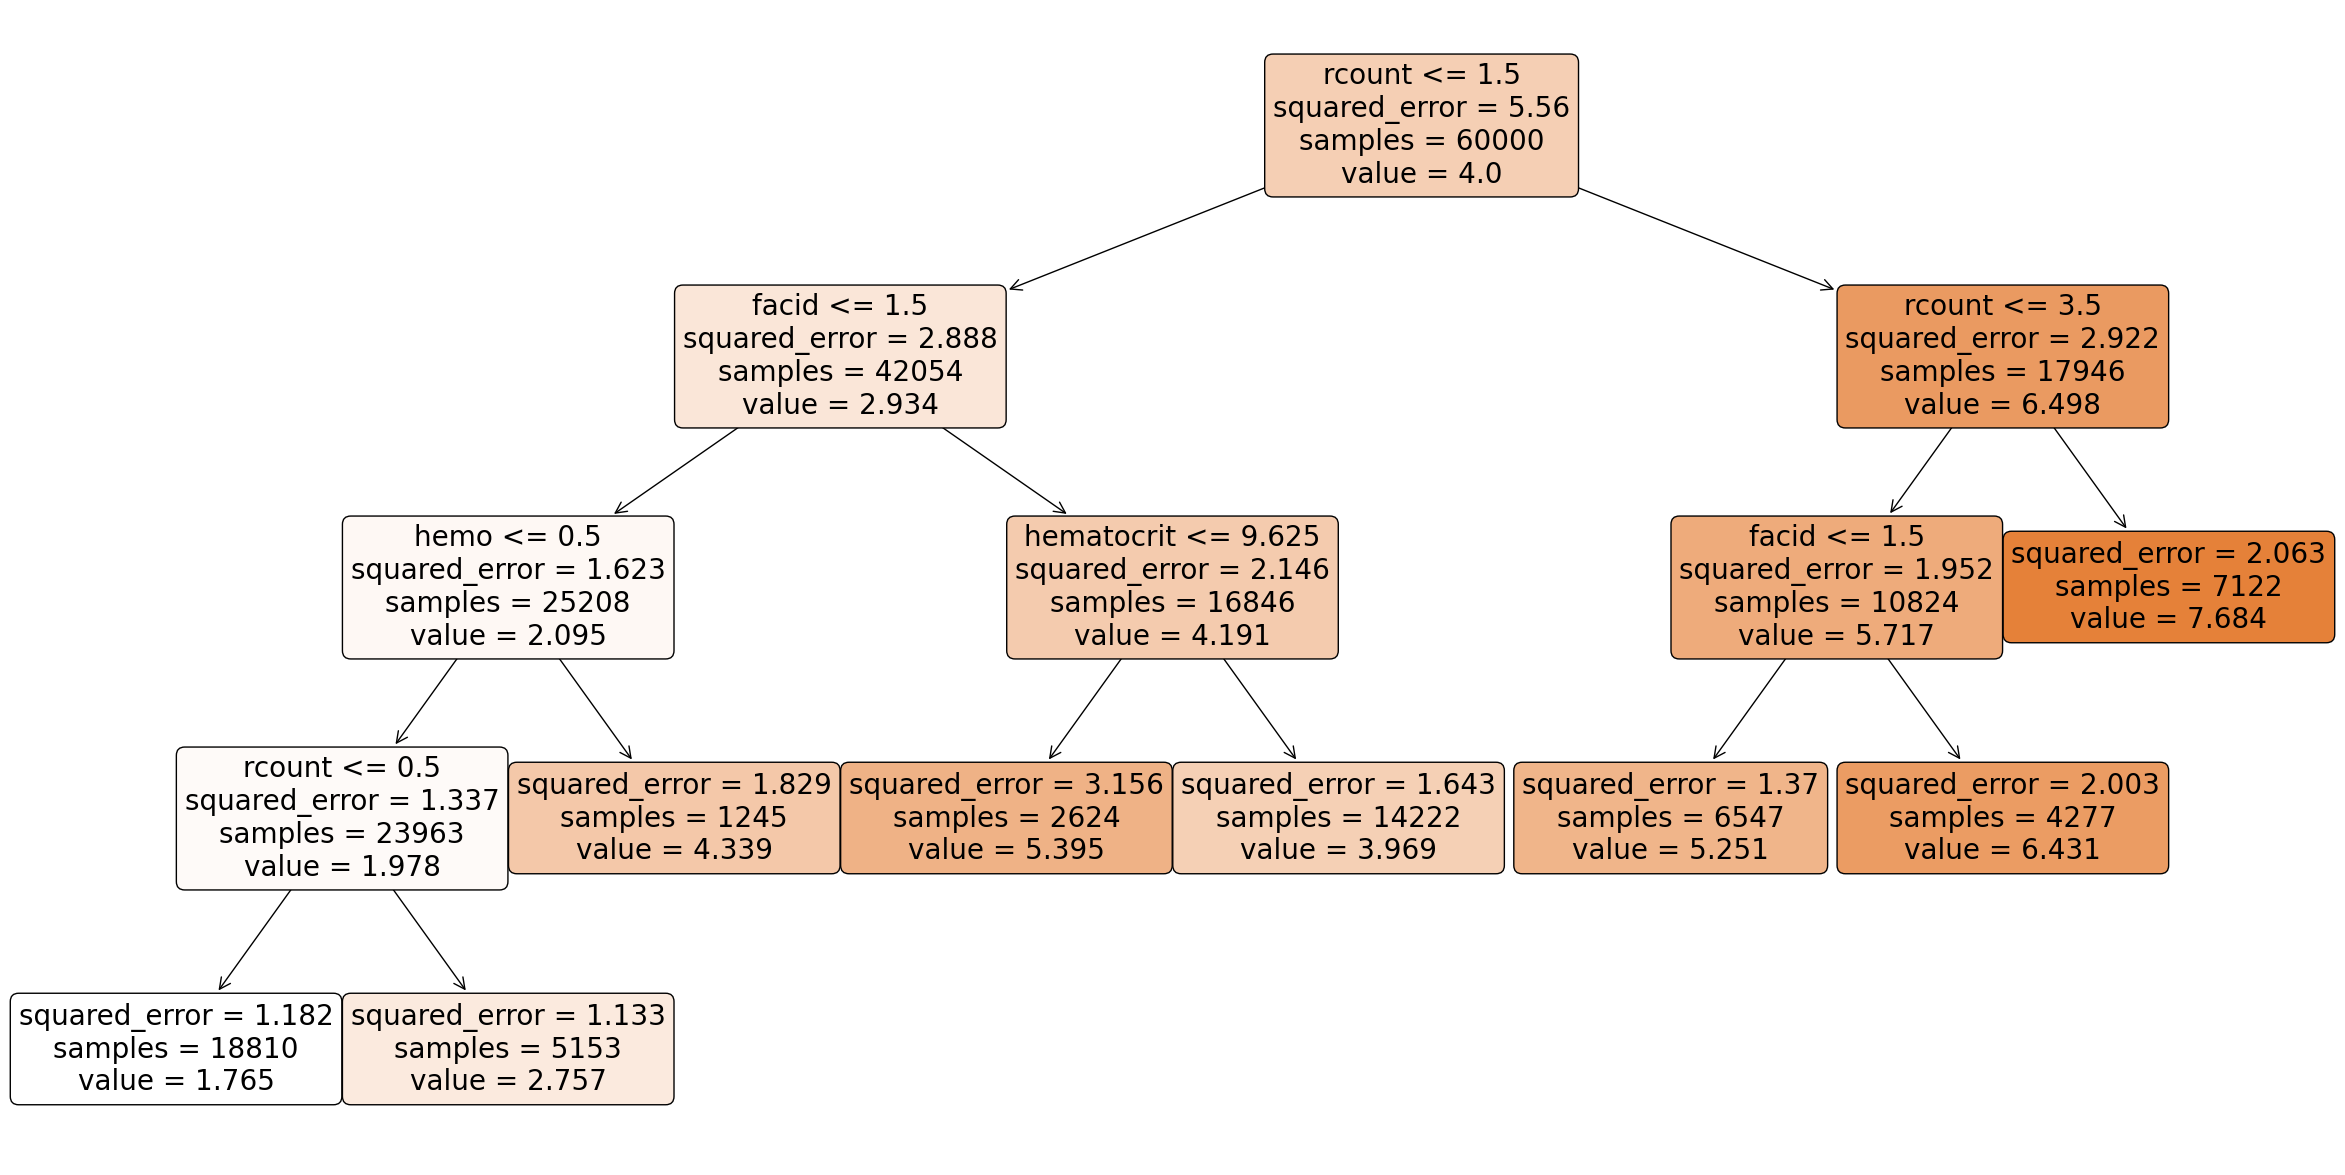

In [18]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(max_depth= 5, ccp_alpha=0.05, min_samples_split=4, random_state=0)

#addestra l'albero
tree.fit(xML_train, yML_train)

#esegue le predizioni
y_pred = tree.predict(xML_test)

# Calcola MAE, MSE e RMSE in base alle predizioni
mae = mean_absolute_error(yML_test, y_pred)
mse = mean_squared_error(yML_test, y_pred)
rmse = sqrt(mse)

# Aggiunge il modello alla lista modelli
elenco_modelliML.append(('TREE', tree))

# Crea una figura
plt.figure(figsize=(30,15))

# Disegna l'albero
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=features)

# Mostra il plot
plt.show()

# Definizione architettura Random Forest

In [19]:
#definisce la random forest
forest = RandomForestRegressor()

#impostai parametri
forest.set_params(n_estimators=100, max_depth=10)

#addestra la foresta
forest.fit(xML_train, yML_train)

#effettua le predizioni
y_pred = forest.predict(xML_test)

# Calcola MAE, MSE e RMSE a partire dalle predizioni 
mae = mean_absolute_error(yML_test, y_pred)
mse = mean_squared_error(yML_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('FOREST', forest))

# Definizione architettura Ensemble

In [20]:
# Crea i modelli individuali (un albero, un regressore bayesiano e un regressore lineare)
tree1 = DecisionTreeRegressor(max_depth=5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
linear = LinearRegression()
bayes = BayesianRidge()

# Crea il modello di ensemble
ensemble = VotingRegressor(estimators=[('tree', tree1), ('linear', linear), ('bayes', bayes)])

# Allena il modello utilizzando i dati di addestramento
ensemble.fit(xML_train, yML_train)

#effettua le predizioni 
y_pred = ensemble.predict(xML_test)

# Calcola MAE, MSE e RMSE in base alle predizioni
mae = mean_absolute_error(yML_test, y_pred)
mse = mean_squared_error(yML_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('ENSEMBLE', ensemble))

# Prestazione dei modelli di apprendimento automatico

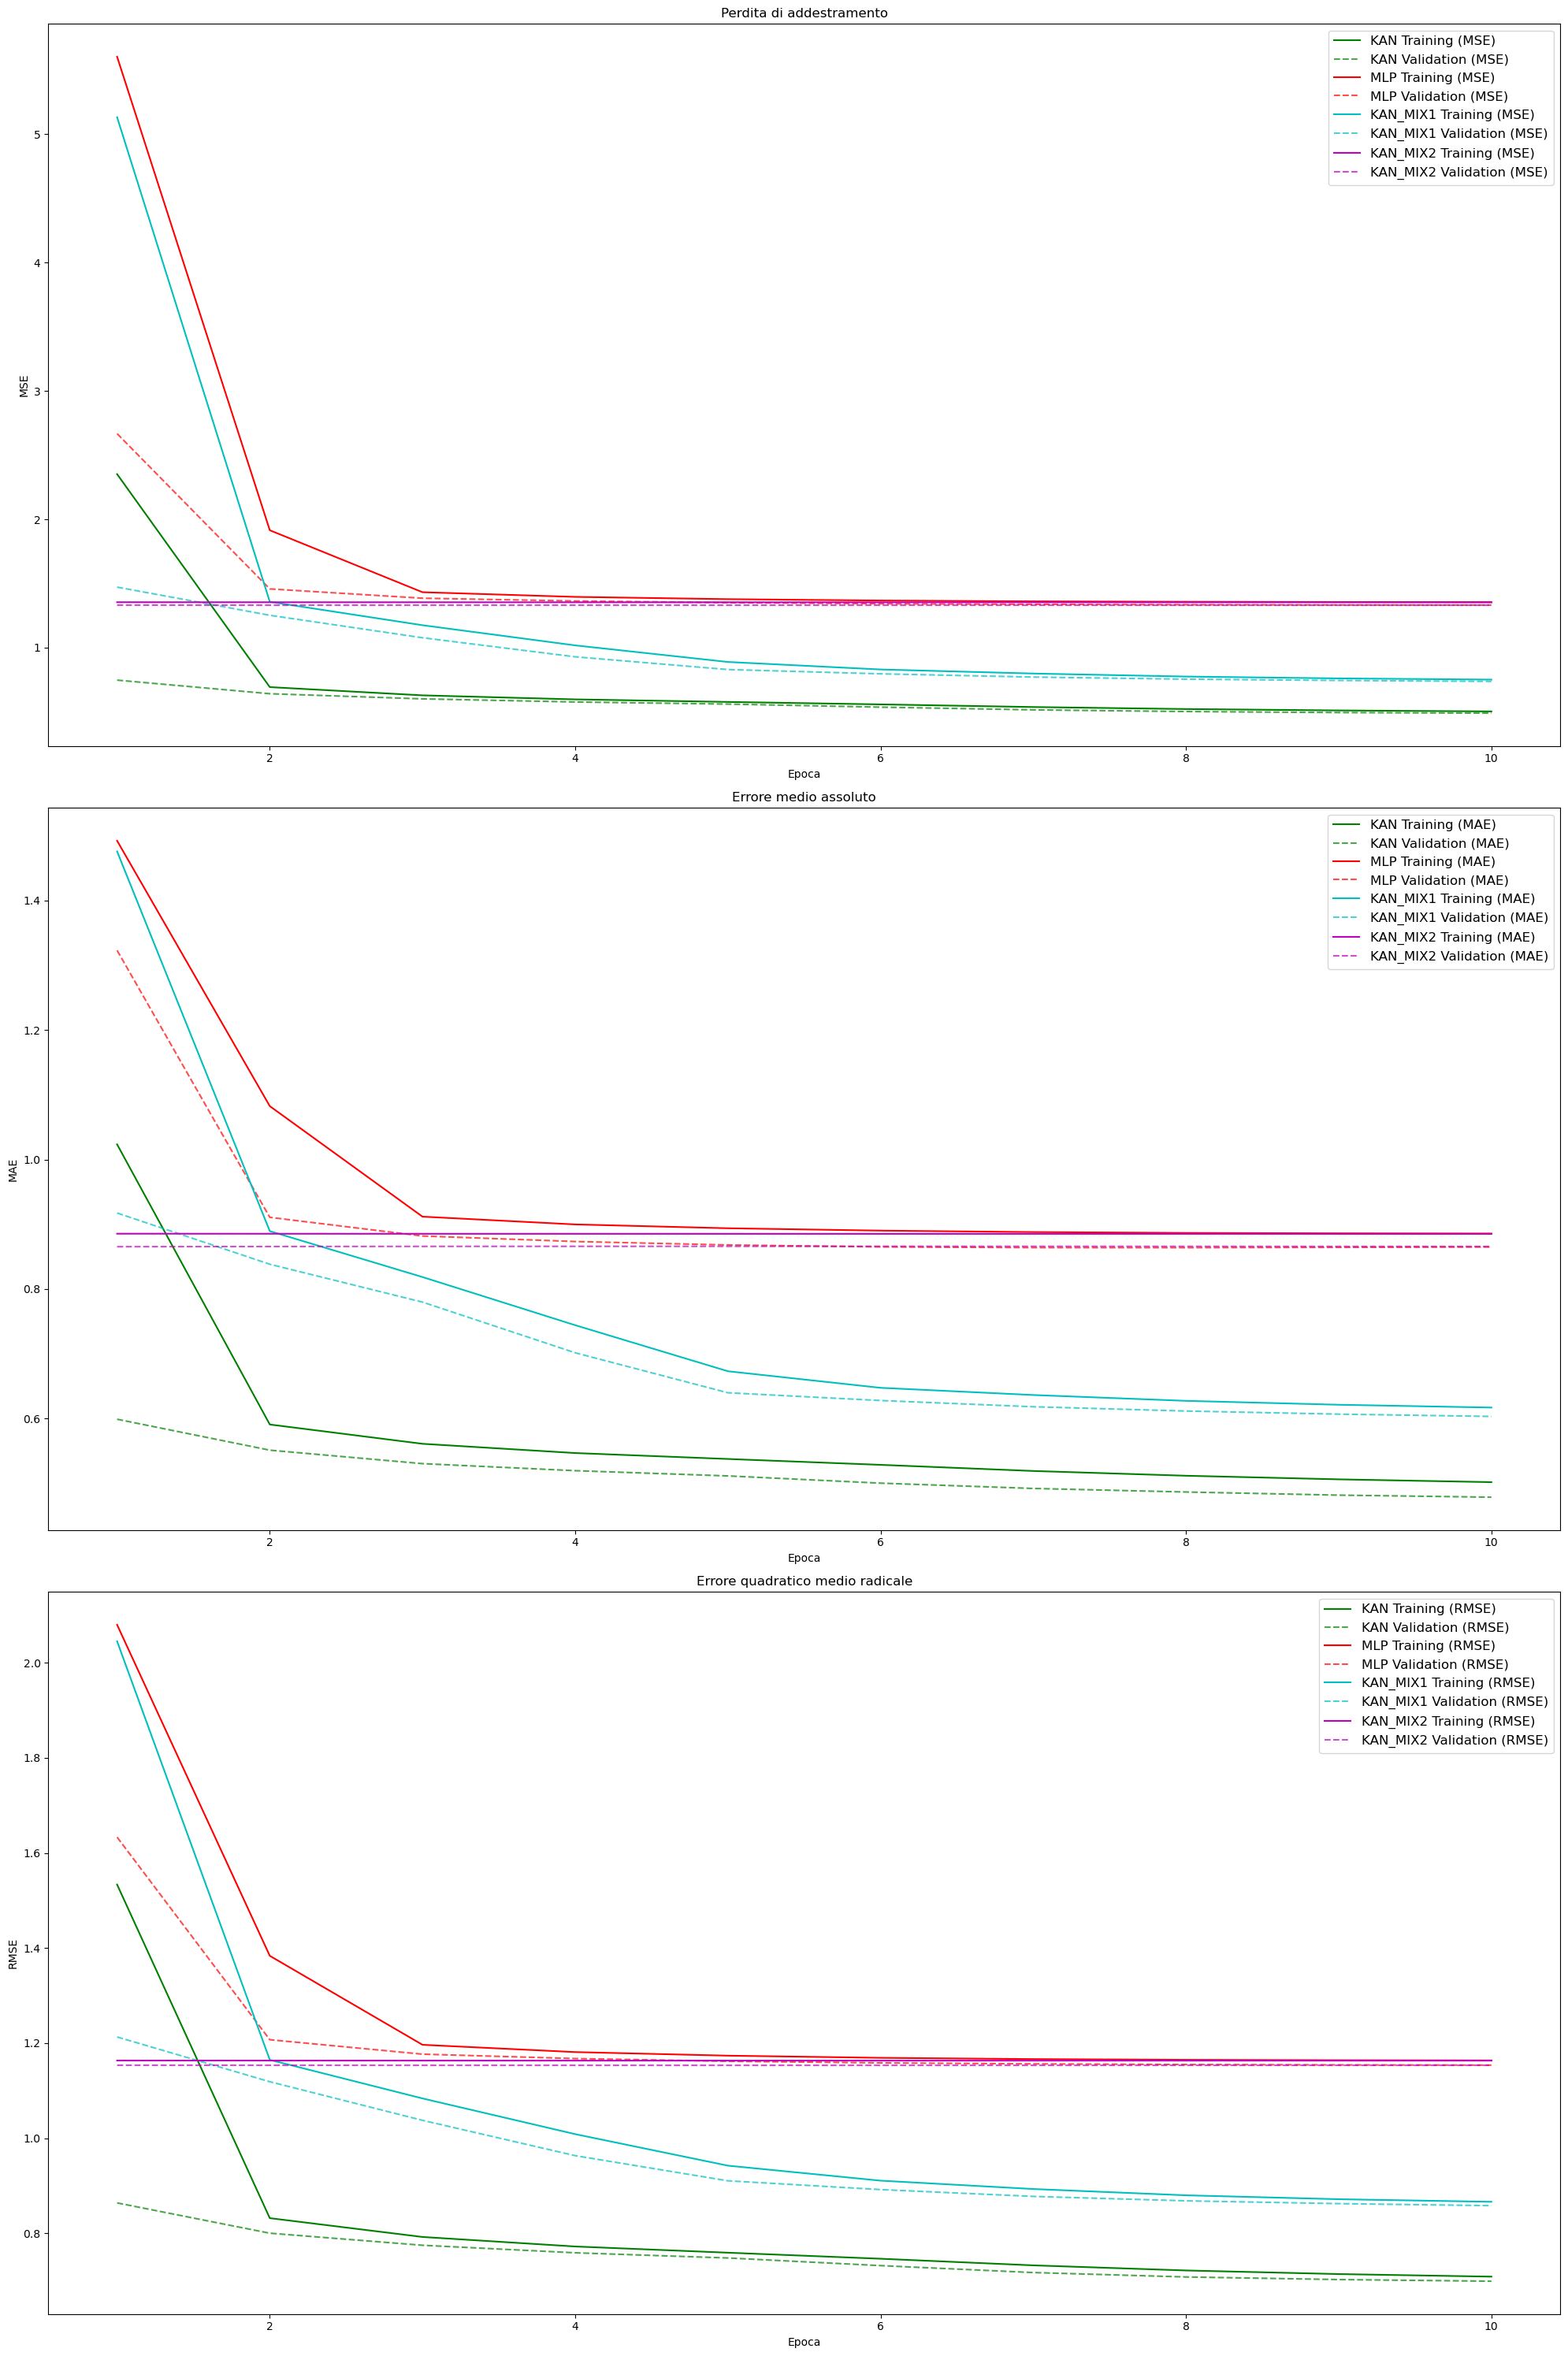

In [21]:
# Crea una lista di colori per rappresentare i vari modelli
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'p']

#inizializza lòa figura
plt.figure(figsize=(20, 30))

#inizializza i a 0
i=0

#per ogni modelli con associato il suo nome nella lista delle hystory dei modelli
for model_name, history in histories:

    #si salva i valori delle performance in delle variabili
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    rmse = history.history['rmse']
    val_rmse = history.history['val_rmse']

    #aumenta il valore del contatore i
    i += 1

    #si calcola il numero di epoche 
    epochs = range(1, len(loss) + 1)

    # Usa lo stesso colore per il training e il validation set di ogni modello
    color = colors[i % len(colors)]

    #crea nei 3 plot le linee con gli andamenti dei modelli al variare delle epoche per i loro tst set e validation set
    plt.subplot(3, 1, 1)
    plt.plot(epochs, loss, color, label=f'{model_name} Training (MSE)') 
    plt.plot(epochs, val_loss, color+'--', alpha=0.7, label=f'{model_name} Validation (MSE)') 
    plt.title('Perdita di addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('MSE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 2)
    plt.plot(epochs, mae, color, label=f'{model_name} Training (MAE)') 
    plt.plot(epochs, val_mae, color+'--', alpha=0.7, label=f'{model_name} Validation (MAE)') 
    plt.title('Errore medio assoluto')
    plt.xlabel('Epoca')
    plt.ylabel('MAE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, rmse, color, label=f'{model_name} Training (RMSE)') 
    plt.plot(epochs, val_rmse, color+'--', alpha=0.7, label=f'{model_name} Validation (RMSE)') 
    plt.title('Errore quadratico medio radicale')
    plt.xlabel('Epoca')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')

#stampa il grafico
plt.tight_layout()
plt.show()

# Analisi equità di genere

Abbiamo valutato varie metriche dei vari modelli per l'attributo gender che rappresenta un attributo sensibile

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


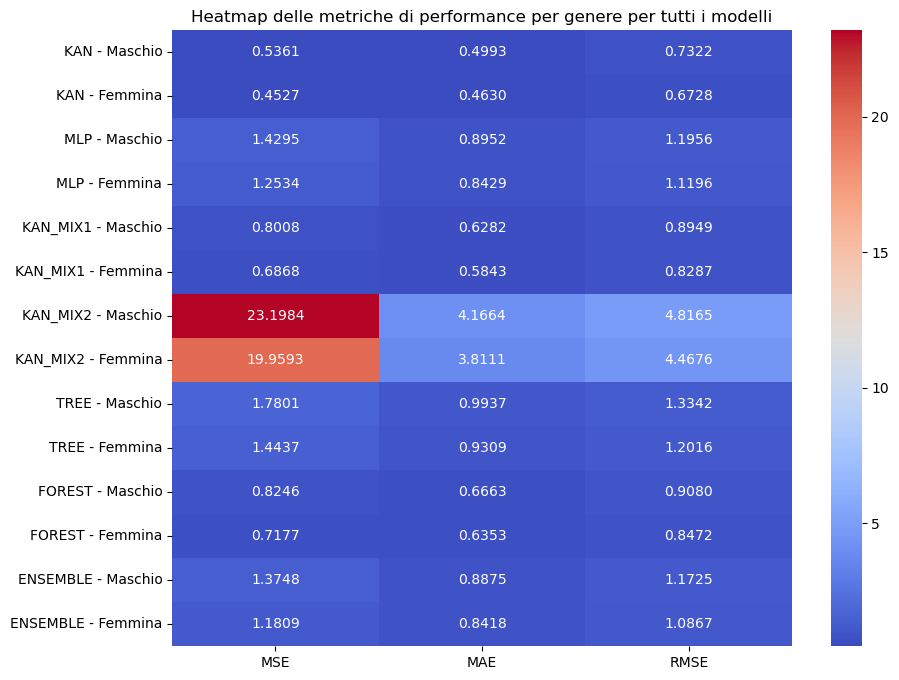

In [22]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

# Per ogni modello nella lista 'elenco_modelli'
for model_name, model in elenco_modelli:

    #crea un dizionario per i risultati delle metriche dei modelli per i vari generi
    results = {}

    #per ogni gruppo nell'elenco dei sottogruppi
    for sg in SUBGROUPS: 
        
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg #crea una maschera booleana
        features1 = x_test[subgroup_indices] #salva i record relativi al sottogruppo corrente
        labels = y_test[subgroup_indices]  #salva le label relative al sottogruppo corrente
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche per ciascun sottogruppo
        mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
        mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]

    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results

# Per ogni modello nella lista 'elenco_modelliML'
for model_name, model in elenco_modelliML:

    #crea un dizionario per i risultati delle metriche dei modelli per i vari generi
    results = {}  

    for sg in SUBGROUPS:  # per ogni gruppo nell'elenco dei sottogruppi

        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = xML_test.iloc[:, CATEGORY] == sg #crea una maschera booleana
        
        features1 = xML_test[subgroup_indices]  #salva i record relativi al sottogruppo corrente
        labels = yML_test[subgroup_indices] #salva le label relative al sottogruppo corrente
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = mean_squared_error(labels, predictions)
        mae_value = mean_absolute_error(labels, predictions)
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]
    
    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results



# Creazione di un DataFrame per visualizzare le metriche di performance di tutti i modelli
df = pd.DataFrame()

#per ogni nome di modello e metrica negli item del dizionario
for model_name, results in all_results.items():

    #si prende le performance di ogi metrica
    temp_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])

    #definisce una nuova colonna
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']

    #concatena la colonna all'insieme di colonne gia definite
    df = pd.concat([df, temp_df], axis=1)

# Conversione dei dati in float
df = df.astype(float)

# Trasposizione del DataFrame per invertire righe e colonne
df = df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = df.min().min()
vmax = df.max().max()

#inizializza la figura
plt.figure(figsize=(10, 8))

# Creazione della heatmap
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)

#imposta il titolo
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')

#mostra il grafico
plt.show()

# Trasparenza algoritmica

## Feature importance

Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.

In [23]:
#calcola la feature importance dei vari modelli
def calculate_feature_importance(model, x_val, y_val):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        # Utilizza l'attributo 'feature_importances_' per i modelli basati su alberi
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')

        #salva l0importanza media di quella feature per le varie previsioni
        importance = results.importances_mean

    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))

    #ritorna il dizionario
    return feature_importance

#lista con le importanze
caratteristiche = []

#calcola l'importanza delle caratteristiche per ogni modello di dl
for nome, modello in elenco_modelli:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

#calcola l'importanza delle caratteristiche per ogni modello di ml
for nome, modello in elenco_modelliML:
    caratteristiche.append((nome, calculate_feature_importance(modello, xML_test, yML_test)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
625/625 ━━━

In [24]:
#funzione che stampa il nome del modello e l'elenco delle caratteristiche con le relative importanze
def stampa_importanza_caratteristiche(caratteristiche):
    # Per ogni modello nella lista 'caratteristiche'
    for nome_modello, importanza_caratteristiche in caratteristiche:
        # Stampa il nome del modello
        print(f"Modello: {nome_modello}")
        
        # Inizializza una variabile 'totale' a 0
        totale = 0
        
        # Per ogni valore di importanza nel dizionario 'importanza_caratteristiche'
        for valus in importanza_caratteristiche.values():
            # Aggiunge il valore assoluto dell'importanza al totale
            totale += abs(valus)
        
        # Per ogni caratteristica e la sua importanza nel dizionario 'importanza_caratteristiche'
        for caratteristica, importanza in importanza_caratteristiche.items():
            # Stampa la caratteristica e la sua importanza normalizzata
            print(f"Caratteristica: {caratteristica}, Importanza: {((importanza / totale)):.2f}")
        
        # Stampa una riga vuota per separare i risultati dei diversi modelli
        print("\n")

# Chiama la funzione 'stampa_importanza_caratteristiche' passando la lista 'caratteristiche'
stampa_importanza_caratteristiche(caratteristiche)

Modello: KAN
Caratteristica: vdate, Importanza: -0.00
Caratteristica: rcount, Importanza: 0.67
Caratteristica: gender, Importanza: 0.00
Caratteristica: dialysis, Importanza: 0.01
Caratteristica: asthma, Importanza: 0.01
Caratteristica: irondef, Importanza: 0.02
Caratteristica: pneum, Importanza: 0.01
Caratteristica: subdep, Importanza: 0.02
Caratteristica: psychmaj, Importanza: 0.07
Caratteristica: depress, Importanza: 0.01
Caratteristica: psychother, Importanza: 0.01
Caratteristica: fibrosis, Importanza: 0.00
Caratteristica: malnutr, Importanza: 0.01
Caratteristica: hemo, Importanza: 0.02
Caratteristica: hematocrit, Importanza: 0.02
Caratteristica: neutrophils, Importanza: 0.00
Caratteristica: sodium, Importanza: 0.02
Caratteristica: glucose, Importanza: 0.02
Caratteristica: bun, Importanza: 0.00
Caratteristica: creatinine, Importanza: 0.02
Caratteristica: bmi, Importanza: 0.02
Caratteristica: pulse, Importanza: 0.02
Caratteristica: respiration, Importanza: 0.02
Caratteristica: secdia

Stampiamo graficamente i risultati della feature importance:

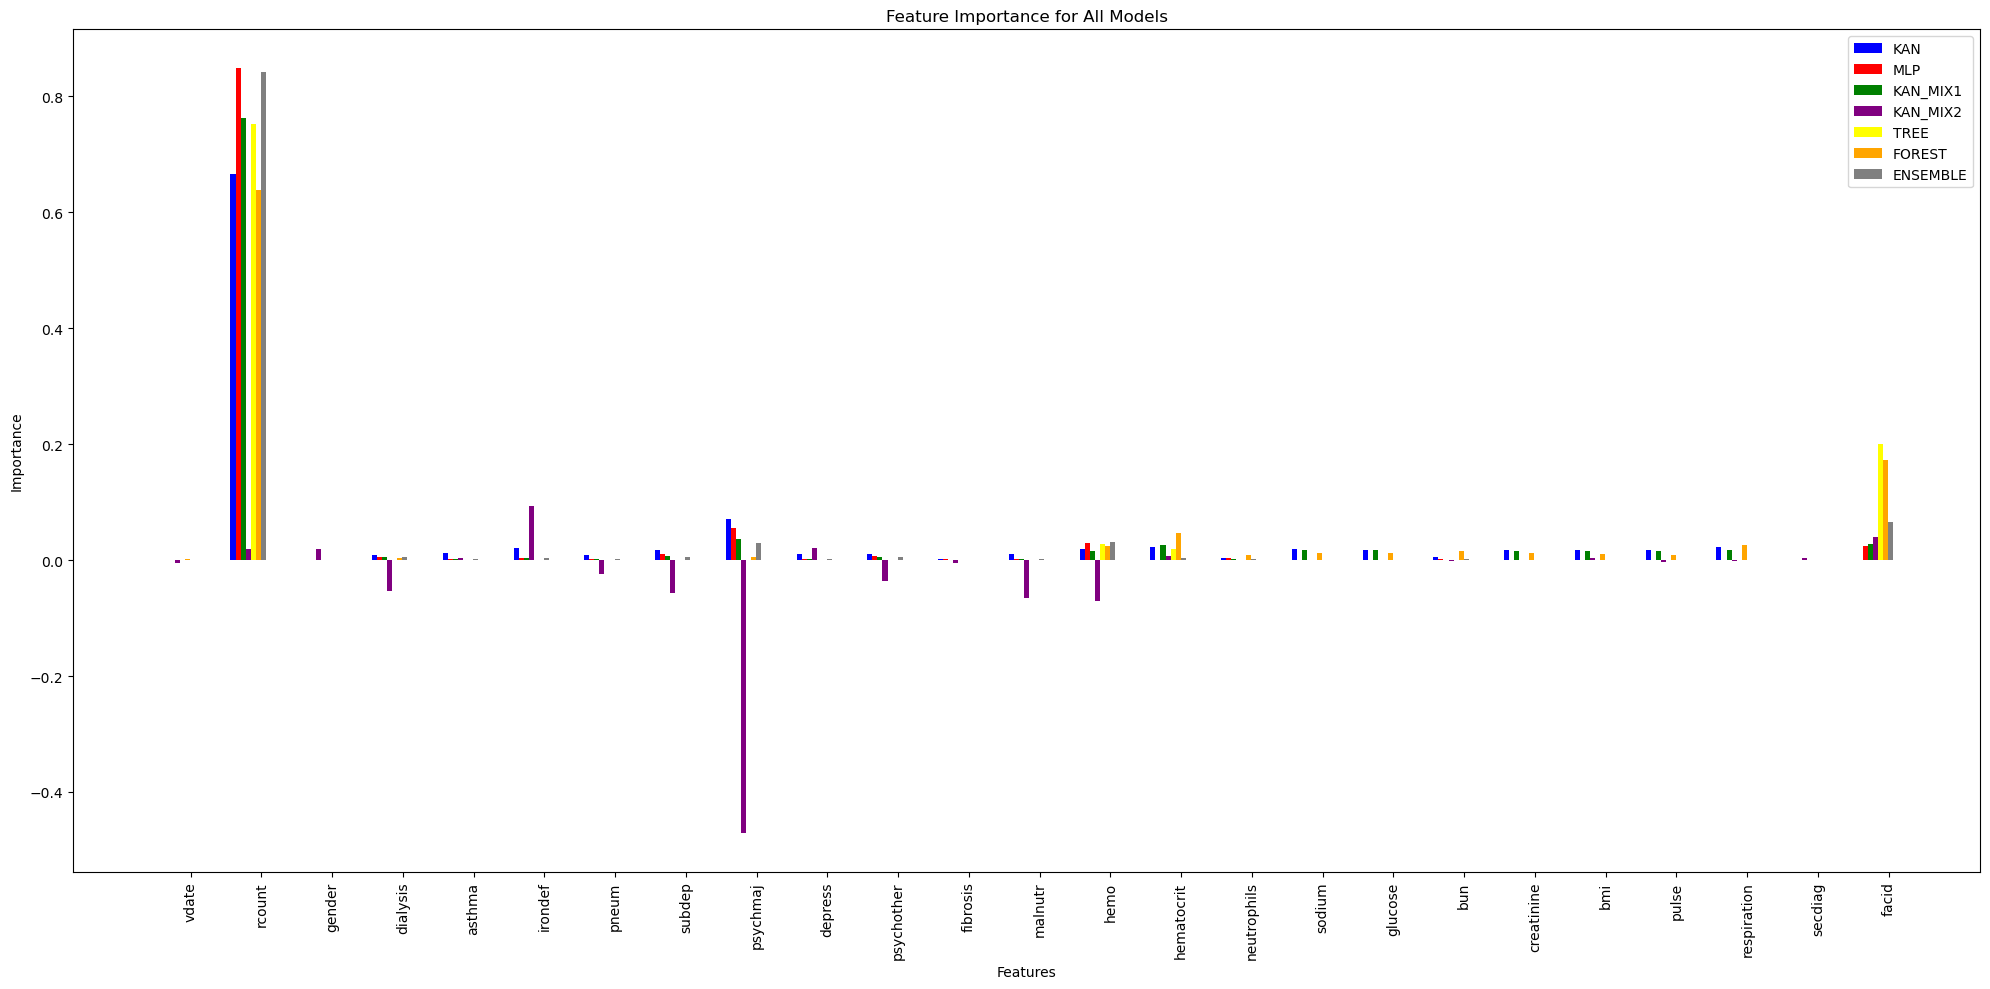

In [25]:
# Inizializza i dizionari per l'importanza delle caratteristiche
importanze = {}

# Calcola l'importanza delle caratteristiche per ogni modello
# Per ogni modello nella lista caratteristiche
for nome, importanza in caratteristiche:
    # Inizializza un nuovo dizionario vuoto per questo modello nel dizionario importanze
    importanze[nome] = {}
    
    # Calcola il totale dell'importanza assoluta di tutte le caratteristiche per questo modello
    totale = sum(abs(imp) for imp in importanza.values())
    
    # Per ogni caratteristica e la sua importanza nel dizionario importanza
    for feature, importance in importanza.items():
        # Calcola l'importanza normalizzata della caratteristica e la salva nel dizionario importanze
        importanze[nome][feature] = importance / totale

# Crea le etichette per l'asse x
features = list(importanze[list(importanze.keys())[0]].keys())
x = np.arange(len(features))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))  # Modifica le dimensioni qui

# Calcola la larghezza delle barre in base al numero di modelli
bar_width = 0.5 / len(importanze)

#definisce i colori da usare per le barre
colors = ['blue', 'red', 'green', 'purple', 'yellow', 'orange', 'grey']  

# Crea le barre per l'importanza delle caratteristiche per ogni modello di un certo colore
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - 0.4 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=colors[i % len(colors)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

# LIME

Il metodo LIME (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le previsioni di modelli complessi tramite modelli interpretabili e locali. LIME perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, LIME costruisce un modello interpretabile (ad esempio, una regressione lineare) sulle predizioni del modello complesso solo per l'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni, rendendo le sue predizioni più comprensibili e trasparenti.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


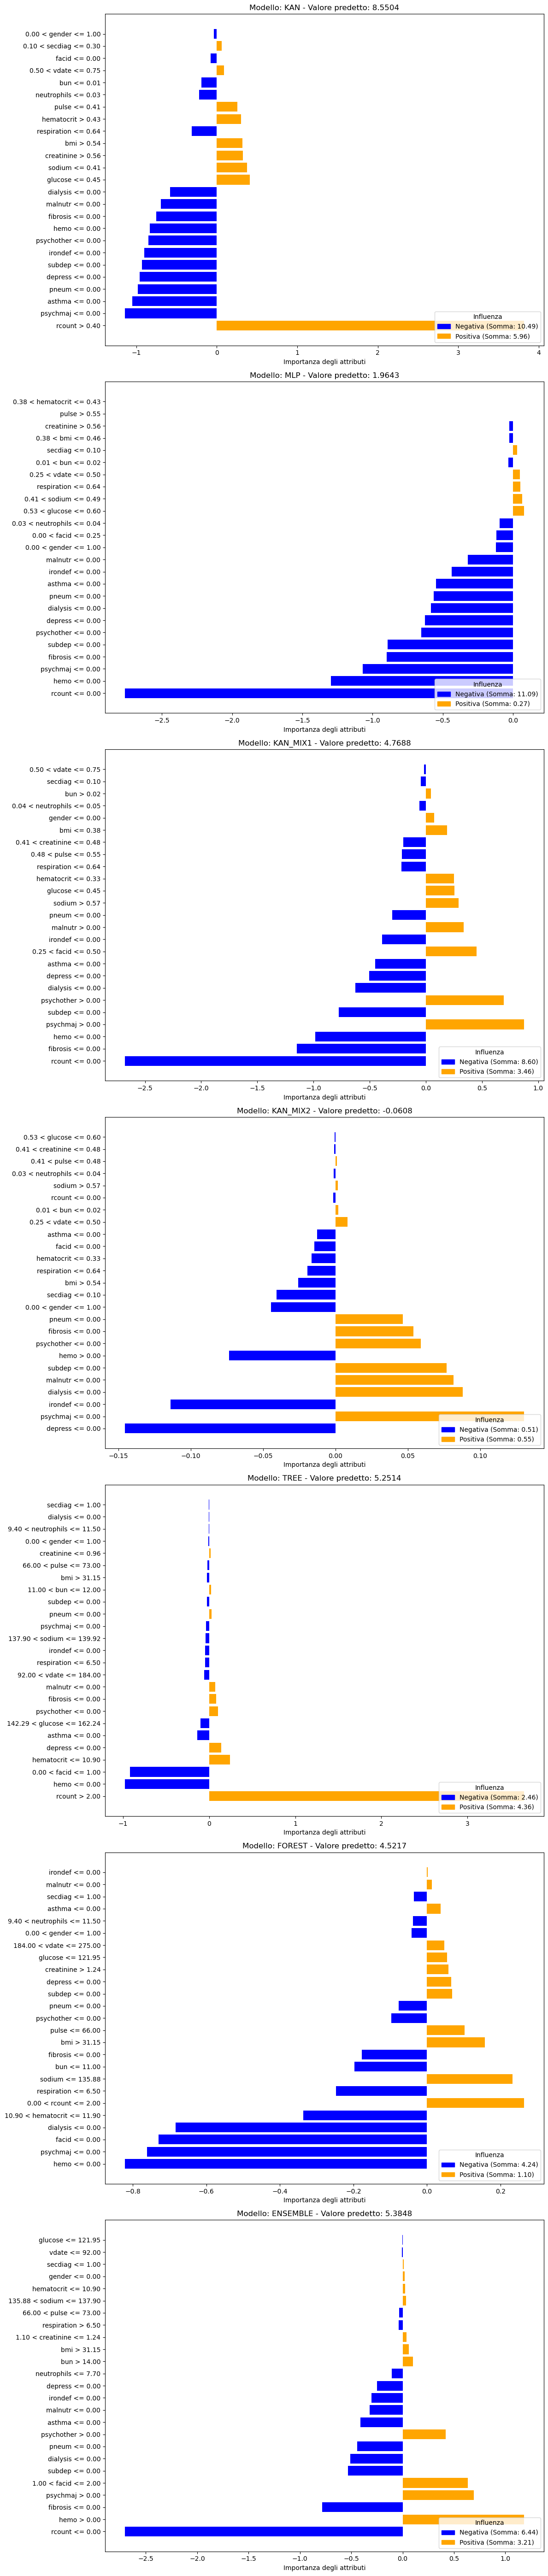

In [26]:
# Definizione della funzione 'check_and_reshape_data' che prende in input un array X e lo ridimensiona se necessario
def check_and_reshape_data(X):
    # Se X ha una sola dimensione, lo ridimensiona a (-1, 1)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    # Se X ha più di due dimensioni, lo ridimensiona a (X.shape[0], -1)
    elif X.ndim > 2:
        return X.reshape(X.shape[0], -1)
    # Altrimenti, restituisce X così com'è
    return X

# Definizione della funzione 'check_and_convert_data' che prende in input un array X e lo converte in un array numpy se necessario
def check_and_convert_data(X):
    # Se X è un DataFrame, restituisce i suoi valori
    if isinstance(X, pd.DataFrame):
        return X.values
    # Se X ha l'attributo 'numpy', restituisce X.numpy()
    elif hasattr(X, 'numpy'):
        return X.numpy()
    # Altrimenti, restituisce X così com'è
    return X

# Definizione della funzione 'apply_lime' che applica LIME a un modello e a un set di dati
def apply_lime(model, X_train, X_test):
    # Conversione di X_train e X_test in array numpy se necessario
    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train.numpy() if hasattr(X_train, 'numpy') else X_train
    X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test.numpy() if hasattr(X_test, 'numpy') else X_test

    # Creazione di un oggetto LimeTabularExplainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_np,
        feature_names=features,
        class_names=['target'],
        mode='regression'
    )
    
    # Definizione della funzione 'model_predict' che prende in input dei dati
    # e restituisce le previsioni del modello su quei dati
    def model_predict(input_data):
        # Ridimensionamento dei dati di input se necessario
        input_data = input_data.reshape(1, -1) if input_data.ndim == 1 else input_data
        # Conversione dei dati di input in un DataFrame o in un tensore tensorflow se necessario
        if isinstance(X_train, pd.DataFrame):
            input_data = pd.DataFrame(input_data, columns=X_train.columns)
        elif hasattr(X_train, 'numpy'):
            input_data = tf.convert_to_tensor(input_data)
        # Restituzione delle previsioni del modello sui dati di input
        return model.predict(input_data)
    
    # Selezione di un'istanza casuale da X_test_np
    instance = X_test_np[random.randint(0, len(X_test_np)-1)]
    # Spiegazione dell'istanza selezionata con LIME
    explanation = explainer.explain_instance(instance, model_predict, num_features=len(features))
    
    # Calcolo della previsione del modello sull'istanza selezionata
    prediction = model_predict(instance.reshape(1, -1))
    # Estrazione del valore predetto dall'array di previsioni
    predicted_value = prediction[0] if isinstance(prediction, np.ndarray) else prediction
    
    # Restituzione della lista di spiegazioni e del valore predetto
    return explanation.as_list(), predicted_value

# Definizione della funzione 'plot_lime_results' che prende in input tutti i risultati di LIME
# e li visualizza in un grafico
def plot_lime_results(all_results):
    # Calcolo del numero di modelli
    n_models = len(all_results)
    # Se non ci sono modelli, termina la funzione
    if n_models == 0:
        return
    
    # Creazione di una figura con un subplot per ogni modello
    fig, axs = plt.subplots(n_models, 1, figsize=(12, 8*n_models), squeeze=False)
    
    # Per ogni modello nei risultati
    for i, (model_name, feature_importance, predicted_value) in enumerate(all_results):
        # Estrazione degli attributi e delle importanze
        attributi, importances = zip(*feature_importance)
        # Assegnazione di un colore a ciascuna importanza in base al suo segno
        colors = ['blue' if imp < 0 else 'orange' for imp in importances]
        
        # Creazione di un grafico a barre orizzontali con le importanze
        ax = axs[i, 0]
        bars = ax.barh(range(len(attributi)), importances, color=colors)
        ax.set_yticks(range(len(attributi)))
        ax.set_yticklabels(attributi)
        ax.set_xlabel('Importanza degli attributi')
        
        # Conversione del valore predetto in una stringa
        if isinstance(predicted_value, np.ndarray):
            predicted_value_str = ', '.join([f'{v:.4f}' for v in predicted_value.flatten()])
        else:
            predicted_value_str = f'{predicted_value:.4f}'
        
        # Impostazione del titolo del subplot
        ax.set_title(f'Modello: {model_name} - Valore predetto: {predicted_value_str}')
        ax.set_facecolor('white')
        
        # Calcolo della somma delle importanze positive e negative
        positive_sum = sum(abs(imp) for imp in importances if imp > 0)
        negative_sum = sum(abs(imp) for imp in importances if imp < 0)
        
        # Aggiunta di una leggenda con le somme delle importanze
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]
        ax.legend(handles, [f'Negativa (Somma: {negative_sum:.2f})', 
                            f'Positiva (Somma: {positive_sum:.2f})'], 
                  title='Influenza', loc='lower right')
    
    # Ridimensionamento del layout del grafico
    plt.tight_layout()
    # Visualizzazione del grafico
    plt.show()
    
# Inizializzazione di una lista vuota per raccogliere i risultati di LIME per tutti i modelli
all_results = []

# Applicazione di LIME a tutti i modelli in elenco_modelli
for name, model in elenco_modelli:
    try:
        # Calcolo dell'importanza delle caratteristiche e del valore predetto con LIME
        feature_importance, predicted_value = apply_lime(model, x_train, x_test)
        # Aggiunta dei risultati alla lista 'all_results'
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        # Stampa dell'errore se si verifica un'eccezione
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Applicazione di LIME a tutti i modelli in elenco_modelliML
for name, model in elenco_modelliML:
    try:
        # Calcolo dell'importanza delle caratteristiche e del valore predetto con LIME
        feature_importance, predicted_value = apply_lime(model, xML_train, xML_test)
        # Aggiunta dei risultati alla lista all_results
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        # Stampa un errore se si verifica un'eccezione
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Visualizzazione dei risultati
if all_results:
    plot_lime_results(all_results)
else:
    print("Nessun risultato da visualizzare.")


## Grafico Architettura KAN

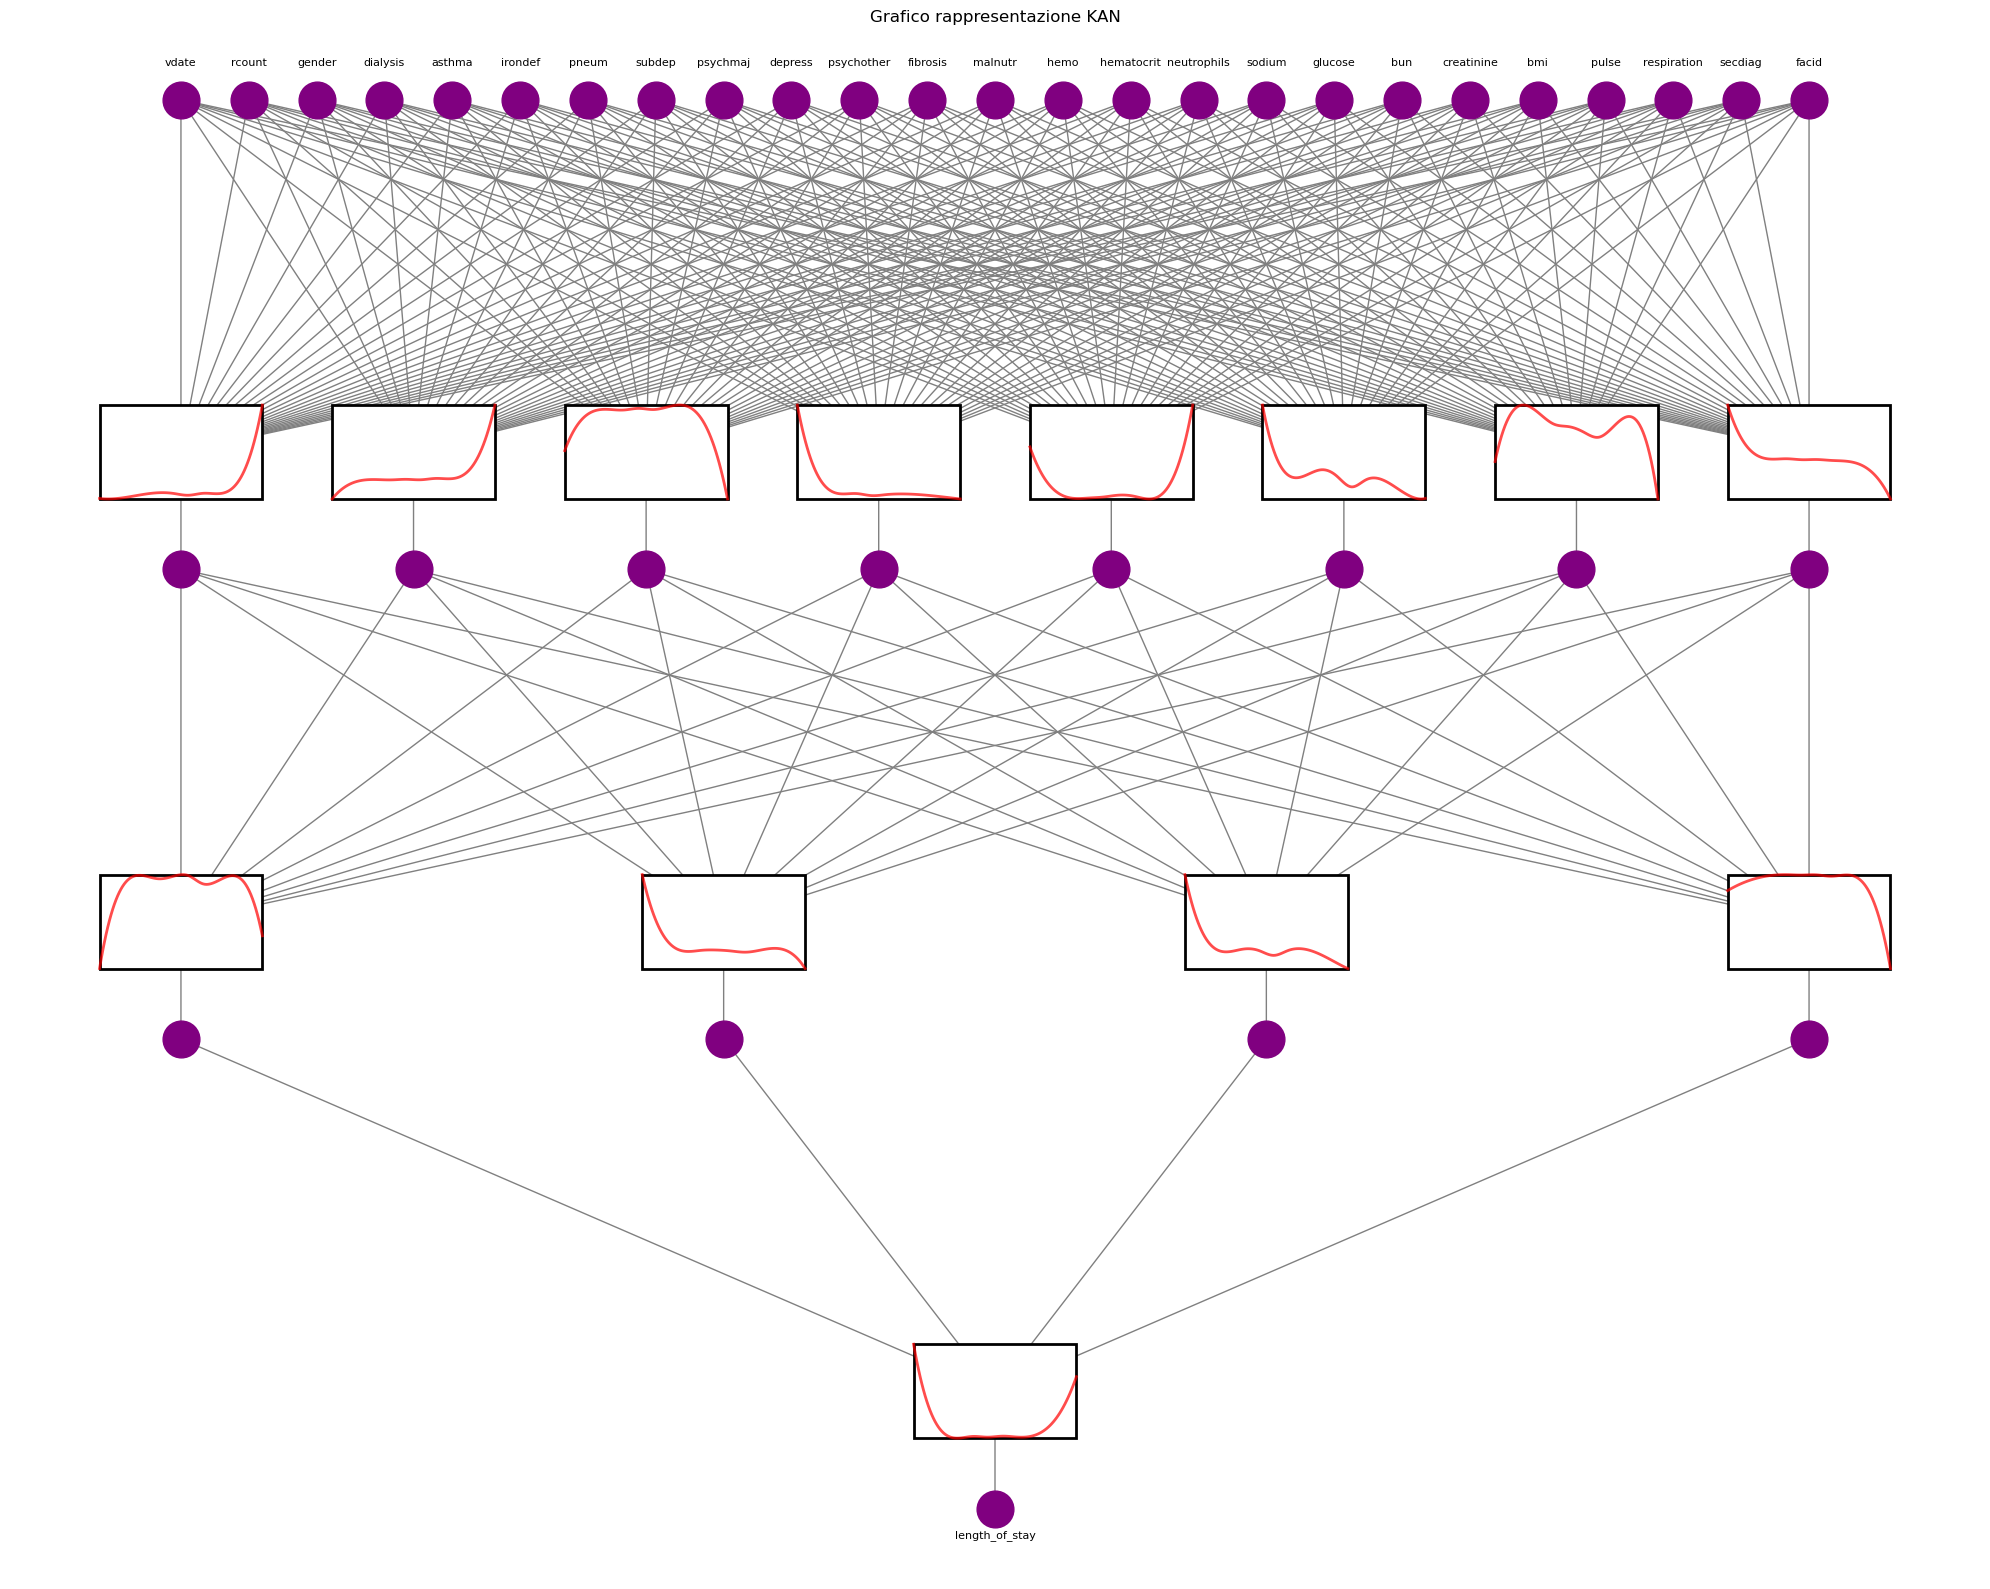

In [27]:
# Definizione della funzione 'get_all_splines_from_model' che estrae tutte le spline da un modello
def get_all_splines_from_model(model):
    # Inizializzazione di una lista vuota per contenere tutte le spline
    all_splines = []
    # Per ogni layer nel modello
    for layer in model.layers:
        # Se il layer è di tipo DenseKAN
        if isinstance(layer, DenseKAN):
            # Aggiunge le spline del layer alla lista di tutte le spline
            all_splines.extend(layer.spline_list)
    # Restituisce la lista di tutte le spline
    return all_splines

# Definizione della funzione 'create_kan_tree_from_model' che crea un grafo da un modello
def create_kan_tree_from_model(model, features):
    # Creazione di un grafo diretto
    G = nx.DiGraph()
    
    # Aggiunta dei nodi di input al grafo
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiunta dei layer nascosti e di output al grafo
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    # Restituisce il grafo
    return G

# Definizione della funzione 'draw_merged_edges' che disegna gli archi e le spline nel grafo
def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    # Inizializzazione di una lista vuota per contenere i punti di fusione
    merge_points = []
    # Per ogni nodo nel grafo
    for target in G.nodes():
        # Ottiene la lista degli archi entranti nel nodo
        in_edges = list(G.in_edges(target))
        # Se ci sono più di un arco entrante
        if len(in_edges) > 1:
            # Calcola la posizione del punto di fusione
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            # Aggiunge il punto di fusione alla lista dei punti di fusione
            merge_points.append(merge_point)
            
            # Per ogni arco entrante
            for source, _ in in_edges:
                # Calcola la posizione di partenza dell'arco
                start = np.array(pos[source])
                # Disegna l'arco dal punto di partenza al punto di fusione
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            # Disegna un arco dal punto di fusione al nodo
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    # Ottiene tutte le spline dal modello
    spline_collection = get_all_splines_from_model(kan)
    square_size = 0.1  # Dimensione fissa del quadrato
    # Per ogni punto di fusione
    for i, point in enumerate(merge_points):
        # Se c'è una spline corrispondente al punto di fusione
        if i < len(spline_collection):
            # Disegna un quadrato attorno al punto di fusione
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Disegna la spline B all'interno del quadrato
            spl = spline_collection[i]
            xx = np.linspace(spl.t[0], spl.t[-1], 100)
            yy = spl(xx)
            
            # Normalizza i valori della spline B per adattarsi al quadrato
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            # Disegna la spline B normalizzata
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    # Restituisce la lista dei punti di fusione
    return merge_points

# Crea un grafo dal modello
G = create_kan_tree_from_model(kan, features)

# Imposta il grafico
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Disegna gli archi e i quadrati con le spline nel grafo
merge_points = draw_merged_edges(G, pos, ax, kan)

# Disegna i nodi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Imposta l'ordine di sovrapposizione per i nodi

# Aggiunge le etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Aggiunge l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

# Imposta il titolo del grafico
plt.title("Grafico rappresentazione KAN")
# Nasconde gli assi
plt.axis('off')
# Ridimensiona il layout del grafico
plt.tight_layout()
# Mostra il grafico
plt.show()

# Confronto prestazioni modelli

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


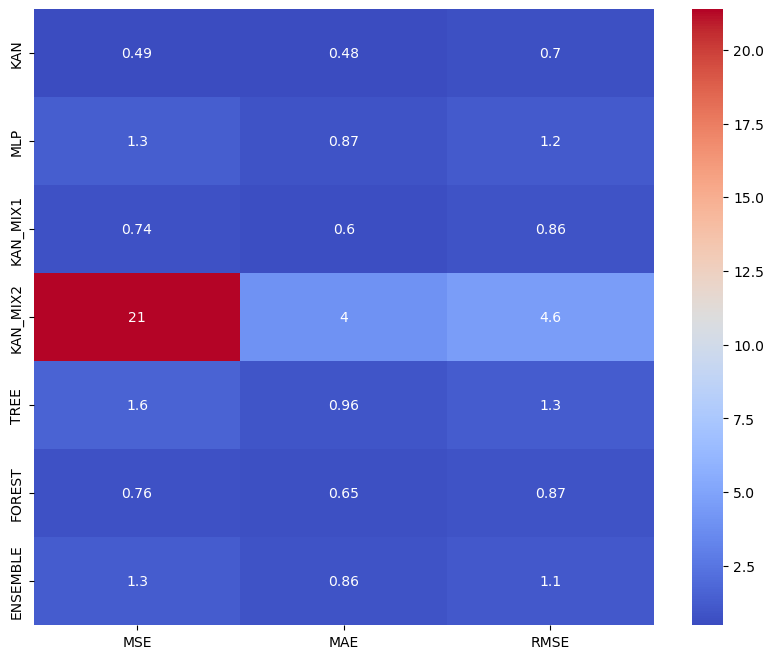

In [28]:
# Definizione della funzione calculate_metrics che calcola le metriche di errore per un modello
def calculate_metrics(model, X, y):
    # Calcolo delle previsioni del modello sui dati X
    predictions = model.predict(X)
    # Calcolo del Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    # Calcolo del Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)
    # Calcolo del Root Mean Squared Error (RMSE)
    rmse = root_mean_squared_error(y, predictions)
    # Restituzione delle metriche calcolate
    return mse, mae, rmse

# Definizione della funzione performance_heatmap che visualizza una heatmap delle performance dei modelli
def performance_heatmap(models, modelsML, X, y, x1, y1):
    # Inizializzazione del dizionario delle performance
    metrics = ['MSE', 'MAE', 'RMSE']
    performance = {metric: [] for metric in metrics}
    model_names = []

    # Per ogni modello nella lista models
    for model_name, model in models:
        # Calcolo delle metriche per il modello corrente
        mse, mae, rmse = calculate_metrics(model, X, y)
        # Aggiunta delle metriche al dizionario delle performance
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        # Aggiunta del nome del modello alla lista dei nomi dei modelli
        model_names.append(model_name)

    # Per ogni modello nella lista modelsML
    for model_name, model in modelsML:
        # Calcolo delle metriche per il modello corrente
        mse, mae, rmse = calculate_metrics(model, x1, y1)
        # Aggiunta delle metriche al dizionario delle performance
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        # Aggiunta del nome del modello alla lista dei nomi dei modelli
        model_names.append(model_name)

    # Creazione di un DataFrame con le performance dei modelli
    df = pd.DataFrame(performance, index=model_names)
    # Creazione di una figura per la heatmap
    plt.figure(figsize=(10, 8))
    # Creazione della heatmap con seaborn
    sns.heatmap(df, annot=True, cmap='coolwarm')
    # Visualizzazione della heatmap
    plt.show()

# Chiamata alla funzione performance_heatmap con i modelli e i dati di test
performance_heatmap(elenco_modelli, elenco_modelliML, x_test, y_test, xML_test, yML_test)


# Tuning (non è da tenere nel notebook, ma era piu comodo averlo direttamente qui)

In [29]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))
        
        for i in range(hp.Int('num_layers', min_value=2, max_value=5)):
            model.add(DenseKAN(
                units=hp.Int('units_' + str(i), min_value=1, max_value=32, step=1),
                grid_size=hp.Int('grid_size_' + str(i), 3, 7),
                spline_order=hp.Int('spline_order_' + str(i), 2, 4)
            ))
        
        model.add(DenseKAN(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'adagrad', 'rmsprop', 'adadelta'])
        
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'adagrad':
            opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)

        model.compile(optimizer=opt,
                    loss='mean_absolute_error',
                    metrics=[
                        tf.keras.metrics.MeanSquaredError(name='mse'),
                        tf.keras.metrics.MeanAbsoluteError(name='mae'),
                        tf.keras.metrics.RootMeanSquaredError(name='rmse')
                    ])
        return model


# Assumo che x_train, y_train siano già definiti
hypermodel = MyHyperModel(input_shape=(numero_feature,))

tuner = BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    directory=r".\modelli_salvati",
    project_name='retina_kan'
)

tuner.search_space_summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=5,
    min_lr=1e-6
)

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print(f"Fold {fold + 1}")
    train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)
    val_indices = tf.convert_to_tensor(val_indices, dtype=tf.int32)
    
    x_train_fold, x_val_fold = tf.gather(x_train, train_indices), tf.gather(x_train, val_indices)
    y_train_fold, y_val_fold = tf.gather(y_train, train_indices), tf.gather(y_train, val_indices)

    tuner.search(x_train_fold, y_train_fold,
                epochs=200,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=[early_stopping, lr_scheduler])

tuner.results_summary()
best_model = tuner.get_best_models(num_models=1)[0]

# Valutazione del modello migliore sul set di test
test_loss, test_mse, test_mae, test_rmse = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

# Salvataggio del modello migliore
best_model.save('best_retina_kan_model.h5')

Reloading Tuner from .\modelli_salvati\retina_kan\tuner0.json
Search space summary
Default search space size: 15
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
grid_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 1, 'sampling': 'linear'}
spline_order_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
grid_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 1, 'sampling': 'linear'}
spline_order_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions':

KeyboardInterrupt: 

In [ ]:
# Ottieni i migliori iperparametri
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Ottieni e stampa i nomi e i valori dei parametri
for param_name in best_hyperparameters.values.keys():
    print(f"{param_name}: {best_hyperparameters.get(param_name)}")

NameError: name 'tuner' is not defined

In [ ]:
# Ottieni i migliori iperparametri per i primi 10 modelli
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)

# Per ogni set di iperparametri
for i, hyperparameters in enumerate(best_hyperparameters):
    print(f"Modello {i+1}")
    # Ottieni e stampa i nomi e i valori dei parametri
    for param_name in hyperparameters.values.keys():
        print(f"{param_name}: {hyperparameters.get(param_name)}")
    print("\n")

NameError: name 'tuner' is not defined